##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Setup

Let's start with importing TF2 and all relevant dependencies.

In [ ]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import glob
from tqdm import tqdm

import os
import shutil
import random
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import cv2
import numpy as np
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import fcos_resnet50_fpn
from torchvision.models.detection import retinanet_resnet50_fpn

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.12.0
TF Hub version:  0.13.0
Eager mode enabled:  True
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


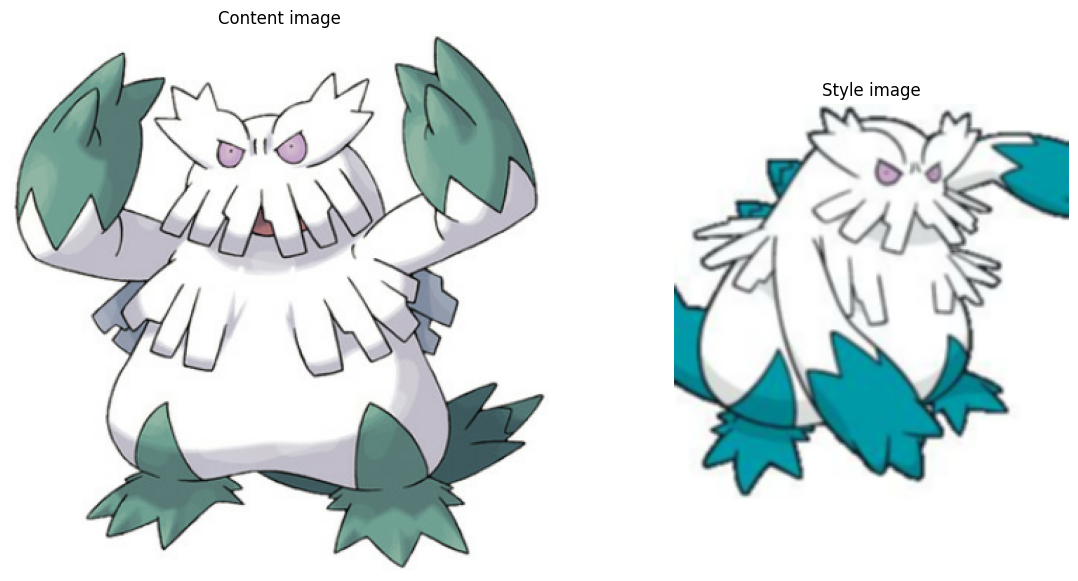

In [ ]:
# @title Load example images  { display-mode: "form" }

content_image_url = '/content/drive/MyDrive/Deep Learning Project/images/Abomasnow/0.jpg'  # @param {type:"string"}
style_image_url = '/content/drive/MyDrive/Deep Learning Project/images/Abomasnow/2.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

## Add new images to the dataset:


100%|██████████| 6831/6831 [05:10<00:00, 22.00it/s]


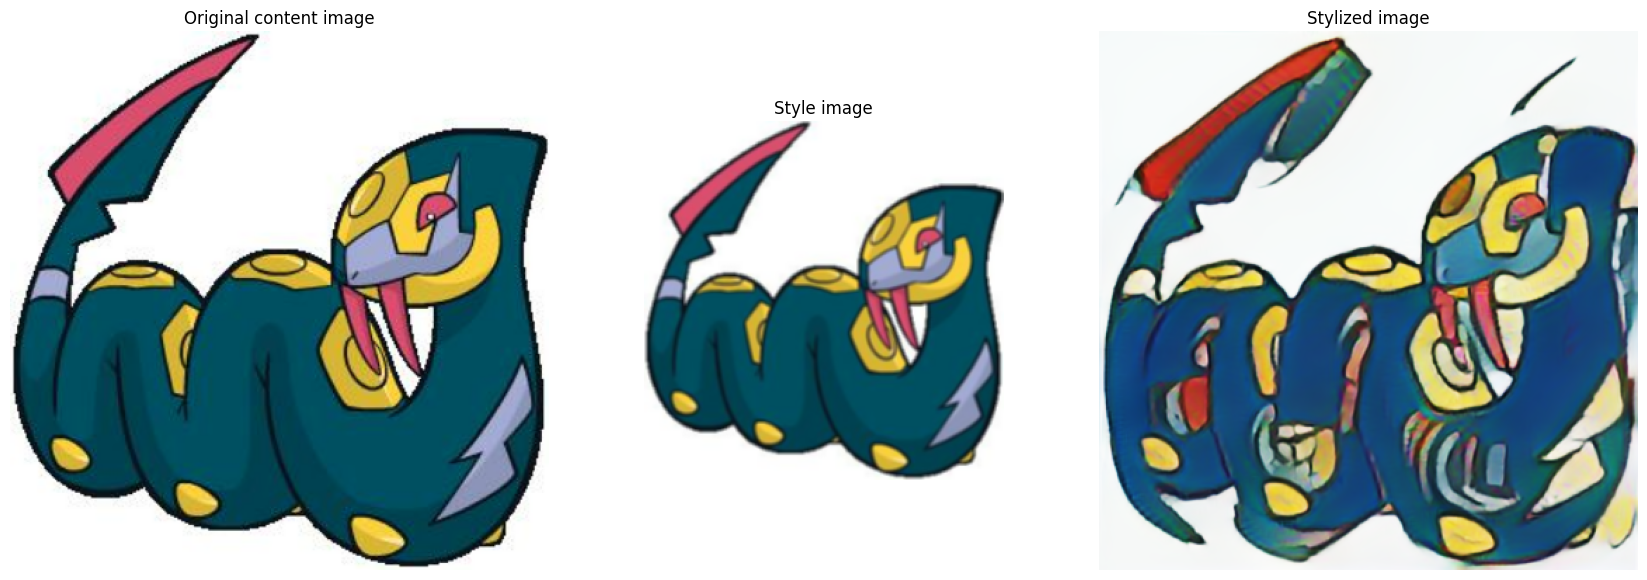

In [ ]:
# change this directory to where you have downloaded the dataset:
files_list = glob.glob("/content/drive/MyDrive/Deep Learning Project/images/*/*.jpg")


output_image_size = 384

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
style_img_size = (256, 256)  # Recommended to keep it at 256.


hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

i = 0
stylized_image = []
for f in tqdm(files_list):
  if (not('styled' in f) and not('Raboot' in f) and 
     not('Eldegoss' in f) and not('Boltund' in f) and not('Greedent' in f) and
      not('Meltan' in f) and not('Clobbopus' in f) and not ('Rookidee' in f) and
      not('Thievul' in f) and not('Chewtle' in f) and not('Cursola' in f) and
      not('Dottler' in f) and not('Runerigus' in f) and not('Spectrier' in f)
      and not('Dragapult' in f) and not('Sizzlipede' in f) and not('Silicobra' in f)
      and not('Gossifleur' in f) and not('Hattrem' in f) and not('Sinistea' in f)
      and not('Milcery' in f) and not('Drakloak' in f) and not('Skwovet' in f)
      and not('Drizzile' in f) and not('Toxel' in f) and not('Thwackey' in f)
      and not('Cufant' in f) and not('Frosmoth' in f) and not('Barraskewda' in f)
      and not('Dubwool' in f) and not('Dracovish' in f) and not('Carkol' in f)
      and not('Glastrier' in f) and not('Blipbug' in f) and not('Hatenna' in f)
      and not('Regieleki' in f) and not('Polteageist' in f) and not('Arctovish' in f)
      and not('Arrokuda' in f) and not('Falinks' in f) and not('Morgrem' in f)
      and not('Mr. Rime' in f) and not('Corvisquire' in f) and not('Perrserker' in f)):
    new = []
    newnew = []
content_image_url = "f"
    new = list(content_image_url)
    newnew = new[0:len(content_image_url)-4]
    save_url = "".join(newnew)+"_styled_v01.jpg"
    new[len(content_image_url)-5] = '1'
style_image_url = "\"\".join(new)"
    if os.path.exists(style_image_url):
      content_image = load_image(content_image_url, content_img_size)
      style_image = load_image(style_image_url, style_img_size)
      style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
      outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
      plt.imsave(save_url, np.squeeze(outputs[0])) 

    i+=1

show_n([content_image, style_image, outputs[0]], titles=['Original content image', 'Style image', 'Stylized image'])


# Segmentation and Classification

In [ ]:
# Split data into training and validation sets
def split_data(src, train_dst, val_dst, val_ratio=0.2):
    if not os.path.exists(train_dst):
        os.makedirs(train_dst)
    if not os.path.exists(val_dst):
        os.makedirs(val_dst)

    classes = sorted(os.listdir(src))

    for cls in classes:
        src_cls = os.path.join(src, cls)
        train_cls = os.path.join(train_dst, cls)
        val_cls = os.path.join(val_dst, cls)

        if not os.path.exists(train_cls):
            os.makedirs(train_cls)
        if not os.path.exists(val_cls):
            os.makedirs(val_cls)

        images = os.listdir(src_cls)
        random.shuffle(images)

        split_idx = int(len(images) * (1 - val_ratio))
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        for img in train_images:
            shutil.copy(os.path.join(src_cls, img), os.path.join(train_cls, img))
        for img in val_images:
            shutil.copy(os.path.join(src_cls, img), os.path.join(val_cls, img))

# change the source path accordingly: 
src_data = "/content/drive/MyDrive/Deep Learning Project/images/"

# choose the path to save train and validation sets:
train_data_dir = "/content/drive/MyDrive/Deep Learning Project/Train_v01"
val_data_dir = "/content/drive/MyDrive/Deep Learning Project/Validation_v01"

split_data(src_data, train_data_dir, val_data_dir)

In [ ]:
# Custom dataset class
class PokemonDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.classes = sorted(os.listdir(root))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = []

        for cls in self.classes:
            cls_path = os.path.join(root, cls)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                self.images.append((img_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Load the datasets
# change these paths to where you have saved the augmented data
train_data = PokemonDataset("/content/drive/MyDrive/Deep Learning Project/Train_v01", transform=transform)
val_data = PokemonDataset("/content/drive/MyDrive/Deep Learning Project/Validation_v01", transform=transform)

In [ ]:
# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [ ]:
# Load a pre-trained model (ResNet)
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s]


In [ ]:
# Modify the last layer to match the number of classes
num_features = model.fc.in_features
num_classes = len(train_data.classes)
print(num_classes)
model.fc = torch.nn.Linear(num_features, num_classes)

898


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Train the model
num_epochs = 20
best_val_acc = 0

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # Print progress
        if (i+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Evaluate on validation set
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_acc:.4f}")
    
    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # the path to save the best model, change accordingly:
        torch.save(model.state_dict(), "/content/drive/MyDrive/Deep Learning Project/models/pokemon_stylized_classifier_best.pth")


Epoch [1/20], Step [10/170], Loss: 6.7975
Epoch [1/20], Step [20/170], Loss: 6.8538
Epoch [1/20], Step [30/170], Loss: 6.8218
Epoch [1/20], Step [40/170], Loss: 6.8087
Epoch [1/20], Step [50/170], Loss: 6.8103
Epoch [1/20], Step [60/170], Loss: 6.7805
Epoch [1/20], Step [70/170], Loss: 6.8024
Epoch [1/20], Step [80/170], Loss: 6.7904
Epoch [1/20], Step [90/170], Loss: 6.6617
Epoch [1/20], Step [100/170], Loss: 6.6459
Epoch [1/20], Step [110/170], Loss: 6.6018
Epoch [1/20], Step [120/170], Loss: 6.5614
Epoch [1/20], Step [130/170], Loss: 6.5225
Epoch [1/20], Step [140/170], Loss: 6.5770
Epoch [1/20], Step [150/170], Loss: 6.5137
Epoch [1/20], Step [160/170], Loss: 6.6618
Epoch [1/20], Step [170/170], Loss: 6.6949
Epoch [1/20], Validation Accuracy: 0.0550
Epoch [2/20], Step [10/170], Loss: 6.1523
Epoch [2/20], Step [20/170], Loss: 6.2552
Epoch [2/20], Step [30/170], Loss: 6.1618
Epoch [2/20], Step [40/170], Loss: 5.7831
Epoch [2/20], Step [50/170], Loss: 6.2509
Epoch [2/20], Step [60/170

# Load the latest model and continue training:

This part of the project was done on google colab so in order to prevent problems causing from colab disconnecting, the training process was divided into two consecutive stages.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# load the previously saved model and continue training:
model_path = "/content/drive/MyDrive/Deep Learning Project/models/pokemon_stylized_classifier_best.pth"

model = models.resnet50(pretrained=False)
num_features = model.fc.in_features
num_classes = 898  # Change this to the number of classes in your dataset
model.fc = torch.nn.Linear(num_features, num_classes)
model.load_state_dict(torch.load(model_path))
model.to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 20
best_val_acc = 0

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # Print progress
        if (i+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Evaluate on validation set
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) 
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_acc:.4f}")
    
    # Save the best model
    if val_acc > best_val_acc: 
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/drive/MyDrive/Deep Learning Project/models/pokemon_stylized_classifier_best.pth")


Epoch [1/20], Step [10/170], Loss: 1.8293
Epoch [1/20], Step [20/170], Loss: 1.6518
Epoch [1/20], Step [30/170], Loss: 1.5385
Epoch [1/20], Step [40/170], Loss: 1.5653
Epoch [1/20], Step [50/170], Loss: 1.6197
Epoch [1/20], Step [60/170], Loss: 1.1990
Epoch [1/20], Step [70/170], Loss: 1.5258
Epoch [1/20], Step [80/170], Loss: 1.4227
Epoch [1/20], Step [90/170], Loss: 1.3364
Epoch [1/20], Step [100/170], Loss: 1.1888
Epoch [1/20], Step [110/170], Loss: 1.5366
Epoch [1/20], Step [120/170], Loss: 1.3675
Epoch [1/20], Step [130/170], Loss: 1.5803
Epoch [1/20], Step [140/170], Loss: 1.6474
Epoch [1/20], Step [150/170], Loss: 1.4895
Epoch [1/20], Step [160/170], Loss: 1.8890
Epoch [1/20], Step [170/170], Loss: 2.0016
Epoch [1/20], Validation Accuracy: 0.7410
Epoch [2/20], Step [10/170], Loss: 1.1732
Epoch [2/20], Step [20/170], Loss: 1.6789
Epoch [2/20], Step [30/170], Loss: 1.3401
Epoch [2/20], Step [40/170], Loss: 1.2007
Epoch [2/20], Step [50/170], Loss: 1.4149
Epoch [2/20], Step [60/170

KeyboardInterrupt: ignored

Detect single Pokemons:

In [ ]:
def predict(image_path, model, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        max_prob, max_idx = torch.max(probabilities, dim=1)

    predicted_class = class_names[max_idx.item()]
    confidence = max_prob.item()

    return predicted_class, confidence

In [ ]:
# Load the saved model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/Deep Learning Project/models/pokemon_stylized_classifier_best.pth"
model = models.resnet50(pretrained=False)
num_features = model.fc.in_features
num_classes = 898  # Change this to the number of classes in your dataset
model.fc = torch.nn.Linear(num_features, num_classes)
model.load_state_dict(torch.load(model_path))
model.to(device)

# Load the class names
# change the path to where the training data is saved
train_data_dir = "/content/drive/MyDrive/Deep Learning Project/Train_v01"
class_names = sorted(os.listdir(train_data_dir))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Test on a character picture:
In this case we get a very low confidence score since this is a human chracter and not a Pokemon

In [ ]:
test_image_path = "./test/test_satoshi.jpg"
predicted_class, confidence = predict(test_image_path, model, class_names)
print(f"Predicted class: {predicted_class}, Confidence: {confidence:.4f}")

Predicted class: Snorlax, Confidence: 0.0203


In [ ]:
def predict_folder(folder_path, model, class_names):
    image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('.jpg', '.jpeg', '.png'))]

    results = []
    for img_path in image_paths:
        predicted_class, confidence = predict(img_path, model, class_names)
        results.append((img_path, predicted_class, confidence))

    return results

# Test on multiple images in a folder
test_folder_path = "./test"
results = predict_folder(test_folder_path, model, class_names)

# Print the results
for img_path, predicted_class, confidence in results:
    print(f"Image: {img_path}, Predicted class: {predicted_class}, Confidence: {confidence:.4f}")

Image: /content/drive/MyDrive/Deep Learning Project/test/test_scyther.jpg, Predicted class: Tyranitar, Confidence: 0.3777
Image: /content/drive/MyDrive/Deep Learning Project/test/test_gengar.jpg, Predicted class: Gengar, Confidence: 0.2508
Image: /content/drive/MyDrive/Deep Learning Project/test/test_charzard.jpg, Predicted class: Charizard, Confidence: 0.4764
Image: /content/drive/MyDrive/Deep Learning Project/test/test_satoshi.jpg, Predicted class: Snorlax, Confidence: 0.0203
Image: /content/drive/MyDrive/Deep Learning Project/test/mix1.jpg, Predicted class: Calyrex, Confidence: 0.0524
Image: /content/drive/MyDrive/Deep Learning Project/test/mix2.jpg, Predicted class: Venusaur, Confidence: 0.1374
Image: /content/drive/MyDrive/Deep Learning Project/test/mix3.jpg, Predicted class: Grotle, Confidence: 0.0685
Image: /content/drive/MyDrive/Deep Learning Project/test/test_squirtle.jpg, Predicted class: Larvitar, Confidence: 0.0410
Image: /content/drive/MyDrive/Deep Learning Project/test/mi